<a href="https://colab.research.google.com/github/JaledMC/Learning-Artificial-Vision/blob/master/image_feature_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you don't have the needed libraries, run the next block.

In [0]:
!apt-get -qq install -y libsm6 libxext6 && pip3 install -q -U opencv-python
!pip3 install -q matplotlib
!pip3 install -q numpy
!pip3 install -q requests

In [0]:
# Import the libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Download images

To use the github images, first download the image to local folder.


In [0]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get('https://raw.githubusercontent.com/JaledMC/Learning-Artificial-Vision/master/images/avocados.jpg')
img = Image.open(BytesIO(response.content))
img.save("avocados.png")

response = requests.get('https://raw.githubusercontent.com/JaledMC/Learning-Artificial-Vision/master/images/avocado.png')
img2 = Image.open(BytesIO(response.content))
img2.save("avocado.png")

image = cv2.imread('avocados.png')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image2 = cv2.imread('avocado.png')
image2_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

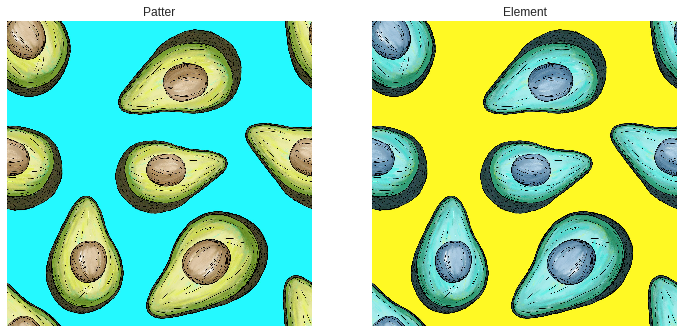

In [3]:
# Represent the image
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(image)
axes[0].set_title('Patter')
axes[1].imshow(image2)
axes[1].set_title('Element')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# Template matching

Not a robust technique, but an easy implementation. The pattern image slide around pixel by pixel throught the original image. The "calculated similarity" is stored in a matrix, where we can find the max value to identify the matching. If we lower this max treshold so much, false detections should be expected. It's possible to apply a mask to the template to suppress unimportat pixels.

This method doesn't support oclusions, shadows, rotation or scaling, but we can make it more robust like [this](https://www.pyimagesearch.com/2015/01/26/multi-scale-template-matching-using-python-opencv/).

In [0]:
import cv2
import numpy as np

# We convert the image to gray, but matching with color is also possible
img_rgb = cv2.imread('opencv-template-matching-python-tutorial.jpg')
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('opencv-template-for-matching.jpg',0)
# Obtain the template size to plot the position squares
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)

# Adjust this value to detect the true templates
threshold = 0.8
# we can use minMaxLoc funtion of openCV too
# min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(res)
axes[0].set_title('Original')
axes[1].imshow(img_rgb)
axes[1].set_title('Original')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

If there are differents objects like the template, with different size, light... conditions, instead of reduce the threshold, it's better to feed the matchTemplate with the objects with different images.

## Edge detection

Convert to gray to subtract the corners coordinates list. Pass it to tuplas with ravel() and plot with circle(). We can adjust the algorithm to detect noise: reduce maxNumber to select obtain only the best know corners. This, with the quality, adjust the thershold confidence for detection. The minimun distance prevents aliasing corners, but same times loss points, like the inner black and red squares of the image.


In [0]:
square = cv2.imread('squares.png')
square = cv2.cvtColor(square, cv2.COLOR_BGR2RGB)
square_gray = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)

# image, 
# max corners to detect: If there are more corners than are found, the strongest of them is returned
# quality (threshold):if the best corner has the quality measure = 1500, and the qualityLevel=0.01 , 
#    then all the corners with the quality measure less than 15 are rejected.
# minimum distance between corners
corners = cv2.goodFeaturesToTrack(square_gray, 100, 0.01, 10)
square_corners = square.copy()

for corner in corners:
    x,y = corner.ravel()
    cv2.circle(square_corners, (x, y), 3, (100, 0, 200), -1)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].imshow(square)
axes[0].set_title('Original')
axes[1].imshow(square_gray, cmap='gray', vmin=0, vmax=255)
axes[1].set_title('Gray')
axes[2].imshow(square_corners)
axes[2].set_title('Corners')
plt.xlabel('Red inner corners no\n detected because min distance')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

In [0]:
chess = cv2.imread('chess.png')
chess = cv2.cvtColor(chess, cv2.COLOR_BGR2RGB)
chess_gray = cv2.cvtColor(chess, cv2.COLOR_BGR2GRAY)
corners = cv2.goodFeaturesToTrack(chess_gray, 250, 0.001, 5)

chess_corners = chess.copy()
for corner in corners:
    x,y = corner.ravel()
    cv2.circle(chess_corners, (x, y), 3, (100, 0, 200), -1)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(chess_gray, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Original')
axes[1].imshow(chess_corners,  cmap = 'jet')
axes[1].set_title('Corners')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

## Feature Matching Homography Brute Force: ORB

Una versión avanzada del template matching, que muestrean por fuerza bruta una imagen sobre otra en buscade coincidencias. Existen distintos algoritmos: SURF, SHIFT (privativos), ORB... este último es robusto a las rotaciones, aunque no tanto a los cambios de escala. Pero es muy rápido, muy útil para procesamiento en vídeo o en móviles. Identifican una seria de keypoints y sus características, en una imagen,y buscan en otras putos similares.
Una vez localizado los puntos, se puede dar por idetificado el objeto y trabajar sobre el ROI,

In [0]:
img1 = cv2.imread('fish.png', 0)
img2 = cv2.imread('fishBank.png', 0)

# create the ORB object
orb = cv2.ORB_create()

# Obtain keypoints and descriptions of both images. Image, mask
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Instance the matcher object. Hamming type, and selec only the best match for each keypoint
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# match descriptions of both photos, by their distance (difference measurement)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

# we draw the matches in both images. We select the best 5 matches, not appliying a mask, to paint all of them. With
#flags = 2, no keypoints without match are draw.
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:5], None, flags=2)
plt.imshow(img3)
plt.show()

Suele tener buen acierto en el objeto, aunque relaciona partes distintas a veces. Está claro que rotar la imagen genera difertes resultados. No parece que reconozco al juguete de la foto, pues la escala es mug distinta. Más bien relaciona la forma.


In [0]:
img1 = cv2.imread('toys.png', 0)
img2 = cv2.imread('toy.png', 0)
img3 = cv2.imread('toy2.png', 0)

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)
kp3, des3 = orb.detectAndCompute(img3, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

matches2 = bf.match(des1,des3)
matches2 = sorted(matches2, key = lambda x:x.distance)

img4 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None, flags=2)
img5 = cv2.drawMatches(img1,kp1,img3,kp3,matches[:10],None, flags=2)
plt.imshow(img4)
plt.show()
plt.imshow(img5)
plt.show()

## Hough Line Transform Hough Circle Transform

In [0]:
# First convert the image to a binary image
img = cv2.imread('lines.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 250, 150, apertureSize = 3)
# image, step p resolution (in this case, 1 pixel), angle o resolution (1 degree), votes threshold
lines = cv2.HoughLines(edges, 1, np.pi/180, 160)
# Function output is an array with every line expresed as distance and angle
for line in lines:
    # extract parameters,obtain the origin and slope (1000 to paint a long line)
    rho,theta = line[0] 
    a = np.cos(theta) 
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
# See the results. # Every line as two edges in the mask. This produce dual detection line
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(edges, cmap='gray')
axes[0].set_title('Mask')
axes[1].imshow(img)
axes[1].set_title('Lines')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

In [0]:
import cv2
import numpy as np

# Aply blur on the image to prevent noise
img = cv2.imread('eye2.jpg', 0)
img = cv2.medianBlur(img, 5)
# add two channels to the image
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
# image, method, acumulator resolution, min_distance between radius, 
# param1 = it is the higher threshold of the two passed to the Canny() edge detector (the lower one is twice smaller)
# param2 = votes acumulator. Circles, corresponding to the larger accumulator values, will be returned first.
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT, 1, 200,
                            param1=120, param2=20, minRadius=20,maxRadius=200)
# Paint the center and perimeter of every circle. Circles is a list with every (x position, y position, radius)
for circle in circles[0, :]:
    # draw the outer circle
    cv2.circle(cimg, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)
    # draw the center of the circle
    cv2.circle(cimg,(circle[0], circle[1]), 2, (0, 0, 255), 3)
# edge image seen by the hought function
edges = cv2.Canny(img, 120, 60)
# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(edges, cmap='gray')
axes[0].set_title('Edges')
axes[1].imshow(cimg)
axes[1].set_title('Circles')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])